# MIS 583 Assignment 4 : Deep Fashion

Before we start, please put your name and ID in following format: <br>
NAME, ?000000000   e.g. 翁聖淇, M094020005

**Your Answer:**   
Hi I'm 吳佩玲, M094020050

**Task 1 - Category**

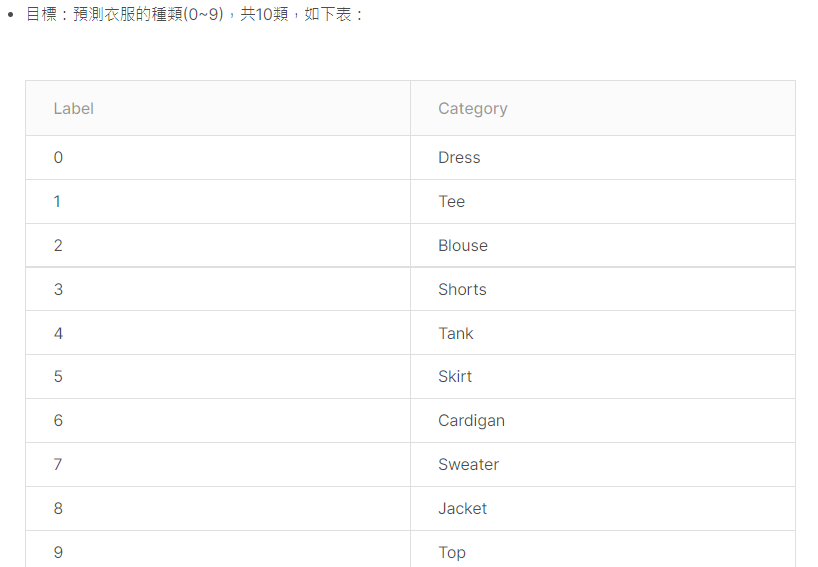

**Task 2 - Attributes**

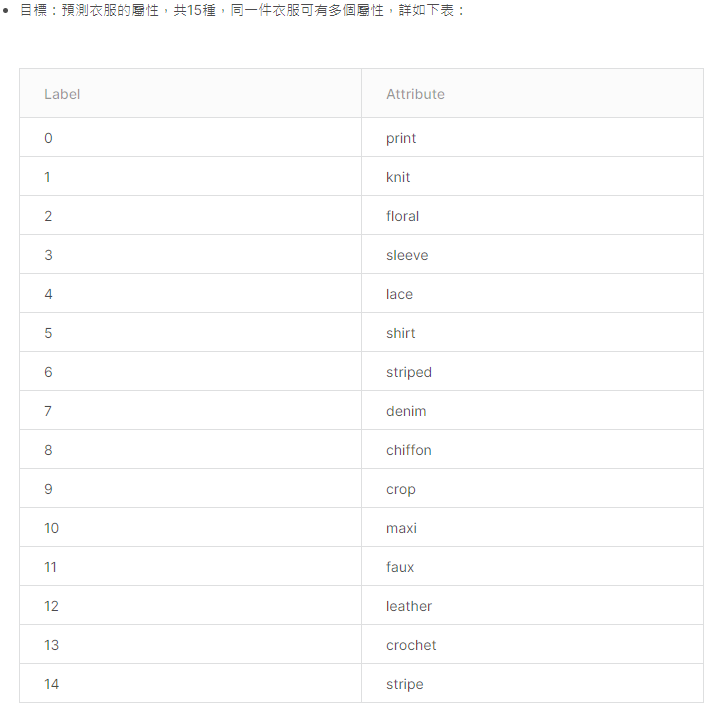

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

I use `python 3.8.11`, `torch==1.8.2` and `torchvision==0.9.2`

In [1]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
torch 1.7.0
torchvision 0.8.1


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。
> The reason of this error is over-sized batch_size or unreleased memory. If changing the batch_size smaller still cause this error. Please reload colab follow below instructions.

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk



# Prepare Data

1. Executing the below code which will provide you with an authentication link
2. Open the link
3. Choose the Google account whose Drive you want to mount
4. Allow Google Drive Stream access to your Google Account
5. Copy the code displayed, paste it in the text box as shown below, and press Enter
![](https://i1.wp.com/neptune.ai/wp-content/uploads/colab-code-copy.png?resize=512%2C102&ssl=1)

Finish!

---

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

Unzip Data

Unzip `assignment_3_data_flowers_2021.zip`, there are 2 folders and 3 csvs.

In [2]:
data_folder = 'hw3'

## Loading the dataset


### Custom dataset

Build a classs inherit `torch.utils.data.Dataset`.  
Implement `__init__`, `__getitem__` and `__len__` 3 functions.  

Some operations could be there: setting location of dataset, the method of reading data, label of dataset or transform of dataset.

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

---

繼承自定義資料集的框架 `torch.utils.data.Dataset`，主要實現 `__getitem__()` 和 `__len__()` 這兩個方法。

常使用來做到設定資料位址、設定讀取方式、子資料集的標籤和轉換條件...等。

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [3]:
import csv
import os
import numpy as np
from PIL import Image
import torch

In [68]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class FashionData(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.labels = []
        self.attribute_label = []
        self.transform = transform
        
        with open(f'{data_folder}/{csv_file}', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                self.data_list.append(f"{data_folder}/{row['file_path']}")
                if mode != 'test':
                    self.labels.append(row['category_label'])
                    z_list = [0]*15 #放15個屬性
                    for k in row['attribute_label'].split(): 
                      z_list[int(k)] = 1
                    self.attribute_label.append(z_list)

    def __getitem__(self, index):
        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        label = torch.tensor(int(self.labels[index]))
        attribute_label = torch.tensor(self.attribute_label[index])

        return data, label , attribute_label

    def __len__(self):
        return len(self.data_list)


### Data augmentation 

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://pytorch.org/vision/stable/transforms.html)

**NOTICE**: There are some operations may not be necessary for predict, so we should write one for train and one for others.

In [69]:
from torchvision import transforms
# For TRAIN
########################################################################

transforms_train = transforms.Compose([transforms.RandomResizedCrop(180),
                    #transforms.RandomHorizontalFlip(p=0.5),
                    #transforms.RandomVerticalFlip(p=0.5),
                    #transforms.RandomRotation(90),
                    transforms.ToTensor(), #同時將取值範圍[0, 255]轉換成[0.0, 1.0]
                    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])]) #transforms.CenterCrop(10), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]


# For VAL, TEST
########################################################################
transforms_test = transforms.Compose([transforms.RandomResizedCrop(180),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])]) #transforms.CenterCrop(10)

### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ dataset_train: for training.
+ dataset_val: for validation.
+ dataset_test: for tesing.

In [70]:
dataset_train = FashionData('./deep_fashion/train.csv', mode='train', transform=transforms_train)
dataset_val = FashionData('./deep_fashion/val.csv', mode='val', transform=transforms_test)
dataset_test = FashionData('./deep_fashion/test.csv', mode='test', transform=transforms_test)

In [71]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(0)[0].size())
print("There are", dataset_train.__len__(), "images in dataset_train.")

The first image's shape in dataset_train : torch.Size([3, 180, 180])
There are 39092 images in dataset_train.


### `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [72]:
from torch.utils.data import DataLoader
batch_size = 32
num_workers = 0
train_loader = DataLoader(dataset_train, batch_size=60, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=60, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=60, shuffle=False)

Finally! We have made all data prepared.  
Let's go develop our model.

# Implement CNN using PyTorch

### Define a Convolutional Neural Network

Try to design and train a deep convolutional network from scratch to predict the class label of a flower image. 

You can refer to last assignment about image_classifier, and try to go deep and use more method for better model.

In [73]:
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models

class Your_CNN_Model(nn.Module): 
  def __init__(self): 
    super().__init__()
    ########################################################################
    #TODO: use nn.xxx method to generate a CNN model part             #
    ########################################################################
    self.resnet = models.resnet50(pretrained=True)
    self.fc = nn.Linear(1024,10)
    self.fc2 = nn.Linear(1024,15)
		########################################################################
		#                           End of your code                           #
		########################################################################
    
  def forward(self, x): 
    if not isinstance(x, torch.Tensor):
      x = torch.Tensor(x)
		########################################################################
		#     TODO: forward your model and get output                          #
		########################################################################
		#Category
    C_out = self.resnet(x)
    C_out = self.fc(C_out)

		#Attribute
    A_out = self.resnet(x)
    A_out = nn.Sigmoid(self.fc2(A_out))
		########################################################################
		#                           End of your code                           #
		########################################################################
    return C_out , A_out

In [74]:
model = Your_CNN_Model()
model = model.cuda()
#print(model)

In [75]:
device = torch.device('cuda')
# or
# device = torch.device('cpu')

In [76]:
model = Your_CNN_Model()
model = model.to(device)
#print(model)

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

### Define loss and optimizer

In [77]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
################################################################################
criterion_C = nn.CrossEntropyLoss()
criterion_A = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
################################################################################
criterion_C = criterion_C.cuda()
criterion_A = criterion_A.cuda()

### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

Hint: [torch.max()](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max) or [torch.argmax()](https://pytorch.org/docs/stable/generated/torch.argmax.html)

In [78]:
def train(input_data, model, c_criterion, a_criterion, c_optimizer):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    a_loss_list = []
    a_total_count = 0
    a_acc_count = 0

    c_loss_list = []
    c_total_count = 0
    c_acc_count = 0

    for images, labels,attribute_label in input_data:
        images = images.to(device)
        c_labels = labels.to(device)
        a_labels = attribute_label.to(device)
        ########################################################################
        # TODO: Forward, backward and optimize                                 #
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network’s parameters            #
        # 5. Update the weights of the network                                 #
        ########################################################################
        #Category
        c_optimizer.zero_grad() #zero the parameter gradients
        output = model(images)
        c_loss = c_criterion(output,c_labels) 
        c_loss.backward()
        c_optimizer.step()
        
        
        
        #Attribute
        ########################################################################
        #                           End of your code                           #
        ########################################################################


        ########################################################################
        # TODO: Get the counts of correctly classified images                  #
        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        # Hint 1: use outputs.data to get no auto_grad                         #
        # Hint 2: use torch.max()                                              #
        ########################################################################

        #Category
        _, predicted = torch.max(output.data,1) 
        c_total_count += c_labels.size(0)
        c_acc_count += (predicted == c_labels).sum()
        c_loss_list.append(c_loss)

        #Attribute?
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    # Compute this epoch accuracy and loss
    c_acc = c_acc_count / c_total_count
    c_loss = sum(c_loss_list) / len(c_loss_list)

    a_acc = a_acc_count / a_acc_count_n
    a_loss = sum(a_loss_list) / len(a_loss_list)

    return c_acc, c_loss, a_acc, a_loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [79]:
def val(input_data, model, criterion):
    model.eval()
    
    c_loss_list = []
    c_total_count = 0
    c_acc_count = 0

    a_loss_list = []
    a_acc_count = 0
    a_acc_count_n = 0
    with torch.no_grad():
        for images, labels,attribute_label in input_data:
            images = images.to(device)
            c_labels = labels.to(device)
            a_labels = attribute_label.to(device)

            ####################################################################
            # TODO: Get the predicted result and loss                          #
            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            ####################################################################
            #Category
            output = model(images)
            c_loss = c_criterion(output,c_labels)
            _, predicted = torch.max(output.data,1) # torch.max(x,1) 按列取最大值

            c_total_count += c_labels.size(0)
            c_acc_count += (predicted == c_labels).sum()
            c_loss_list.append(c_loss)


            #Attribute?
            ####################################################################
            #                         End of your code                         #
            ####################################################################

    c_acc = c_acc_count / c_total_count
    c_loss = sum(c_loss_list) / len(c_loss_list)

    a_acc = a_acc_count / a_acc_count_n
    a_loss = sum(a_loss_list) / len(a_loss_list)

    return c_acc, c_loss, a_acc, a_loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [80]:
################################################################################
# You can adjust those hyper parameters to loop for max_epochs times           #
################################################################################
max_epochs = 5
log_interval = 1 # print acc and loss in per log_interval time

c_train_acc_list = []
c_train_loss_list = []
c_val_acc_list = []
c_val_loss_list = []

a_train_acc_list = []
a_train_loss_list = []
a_val_acc_list = []
a_val_loss_list = []


for epoch in range(1, max_epochs + 1):
  #with torch.no_grad():
    c_train_acc, c_train_loss, a_train_acc, a_train_loss = train(train_loader, model, criterion_C, criterion_A, optimizer)
    c_val_acc, c_val_loss, a_val_acc, a_val_loss = val(val_loader, model, criterion_C, criterion_A, optimizer_C, optimizer_A)

    #Category
    c_train_acc_list.append(c_train_acc)
    c_train_loss_list.append(c_train_loss)
    c_val_acc_list.append(c_val_acc)
    c_val_loss_list.append(c_val_loss)

    #Attribute
    a_train_acc_list.append(a_train_acc)
    a_train_loss_list.append(a_train_loss)
    a_val_acc_list.append(a_val_acc)
    a_val_loss_list.append(a_val_loss)

    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Category Train Acc: {:.6f} Category Train Loss: {:.6f}'.format(c_train_acc, c_train_loss))
        print('Category Val Acc: {:.6f}  Category Val Loss: {:.6f}'.format(c_val_acc, c_val_loss))
        print('Attribute Train Acc: {:.6f} Attribute Train Loss: {:.6f}'.format(a_train_acc, a_train_loss))
        print('Attribute Val Acc: {:.6f}  Attribute Val Loss: {:.6f}'.format(a_val_acc, a_val_loss))
################################################################################
#                               End of your code                               #
################################################################################

RuntimeError: mat1 dim 1 must match mat2 dim 0

In [45]:
# save your well-trained state_dict of model
torch.save(model.state_dict(), 'm094020050_1.pt')

#### Visualize accuracy and loss

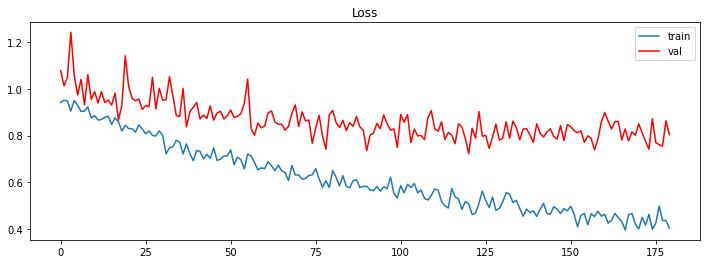

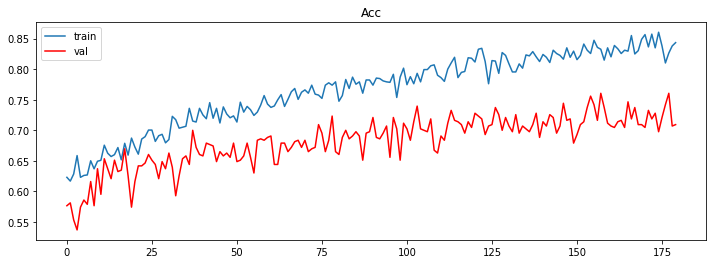

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()

### Predict Result

Predict the labesl based on testing set. Upload to [Kaggle](https://www.kaggle.com/c/mis583-2021-flower-classification).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 70% dataset and publish this result to leaderboard.

---

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/c/mis583-2021-flower-classification)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中70%資料的正確率

In [ ]:
# # if you wanna load previous best model
# ckpt = torch.load('NAME_OF_THIS_EXPERIMENT.pt')
# model.load_state_dict(ckpt) 

In [ ]:
def predict(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for images in input_data:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [ ]:
idx = 0
output_csv = predict(test_loader, model)
with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'label'])
    writer.writeheader()
    for result in output_csv:
        file_path = dataset_test.data_list[idx].replace(data_folder + '/', '')
        writer.writerow({'file_path':file_path, 'label':result})
        idx += 1

# Keep trying and write report

Keep adjust your model, loss function, optimizer...... to train the better model.  
Remember record the output of different setting. It's convenient for your to write the report.

You are on your way!

---

持續調整模型、訓練方法、損失函數、優化器等，來訓練出更好的模型，並記錄使用不同參數得出的效果，以利後續 Report 的撰寫。

大家加油！